# Detección de anomalías y técnicas de agrupamiento

### Objetivos 

Mediante este trabajo se pretende que poner en práctica la aplicación de los algoritmos de detección de anomalías u outliers y las técnicas de agrupamiento. El objetivo es detectar anomalías, generar y analizar agrupaciones aplicando algoritmos de aprendizaje máquina, con el fin de elegir el mejor método para el conjunto de datos dado. Debe detallar los pasos que hay que realizar para la detección automática de valores inusuales y, por otro lado, analizar los clúster o grupos resultado de aplicar un algoritmo de agrupamiento.


#### Sobre los datos:

Se procesaron automáticamente 2126 cardiotocogramas (CTGs) fetales y se midieron las características diagnósticas respectivas. Los CTGs también fueron clasificados por tres obstetras expertos y se asignó una etiqueta de clasificación de consenso a cada uno de ellos. La clasificación fue tanto con respecto a un patrón morfológico (A, B, C...) como a un estado fetal (N, S, P). Por lo tanto, el conjunto de datos se puede utilizar tanto para experimentos de 10 clases como de 3 clases.

* Fecha: de la examinación
* b: instante de inicio
* e: instante de finalización
* LBE: valor basal (experto médico)
* LB: valor basal (SisPorto)
* AC: aceleraciones (SisPorto)
* FM: movimientos fetales (SisPorto)
* UC: contracciones uterinas (SisPorto)
* ASTV: porcentaje de tiempo con variabilidad a corto plazo anormal (SisPorto)
* mSTV: valor medio de la variabilidad a corto plazo (SisPorto)
* ALTV: porcentaje de tiempo con variabilidad a largo plazo anormal (SisPorto)
* mLTV: valor medio de la variabilidad a largo plazo (SisPorto)
* DL: deceleraciones leves
* DS: deceleraciones severas
* DP: deceleraciones prolongadas
* DR: deceleraciones repetitivas
* Width: ancho del histograma
* Min: frecuencia baja del histograma
* Max: frecuencia alta del histograma
* Nmax: número de picos del histograma
* Nzeros: número de ceros del histograma
* Mode: modo del histograma
* Mean: media del histograma
* Median: mediana del histograma
* Variance: varianza del histograma
* Tendency: tendencia del histograma: -1=asimétrico izquierdo; 0=simétrico; 1=asimétrico derecho
* A: sueño tranquilo
* B: sueño REM
* C: vigilia tranquila
* D: vigilia activa
* AD: patrón acelerativo/decelerativo (situación de estrés)
* DE: patrón decelerativo (estimulación vagal)
* LD: patrón mayormente decelerativo
* FS: patrón plano-sinusoidal (estado patológico)
* SUSP: patrón sospechoso
* CLASS: Código de clase (1 a 10) para clases A a SUSP
* NSP: - 

In [39]:
# librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from histograma import crear_histogram
from histograma import boxplot
from outliers import otliers

In [40]:
# leemos el conjunto de datos
data = pd.read_csv("./Datos/CTG.csv")
data.head(3)

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0


De inicio es posible ver sin mucho analisis que podemos eliminar columnas que no nos aportan mucha información: 

**Filename, Date y segfile:** Nos muestra la fecha y nombre de los documentos. Esta información son irrelevantes en este analisis de datos.

**b(instante de inicio), e(instante de finalizacion):**: Nos puede mostrar un numero que representar el primer punto en el inicio y final en la grafica del electrocardiograma. Sin embargo al no tener mucha informacion sobre esta variable se descarta.

**A(sueño tranquilo), B(sueño REM), C(Vigilia tranquila), D(vigilia activa):** Estas variables no aportan mucha información ya que es muy poco probable que tener ritmos anormales durante el sueño ya que este suele estar relacionada con el estrés, la ansiedad y otros factores. 

**DR(deceleraciones repetitivas):**  Esta columna esta en ceros.

**NZeros:** Muestra los 0 del electrocardiograma

**E:** No tenemos información al respecto.

In [41]:
#eliminamos columnas innecesarias
data = data.drop(["FileName","Date",'DR',"Nzeros","SegFile","b","e","A", "B","C", "D" ,"E","DL"], axis=1)
data.head(3)

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DS,...,Median,Variance,Tendency,AD,DE,LD,FS,SUSP,CLASS,NSP
0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,...,121.0,73.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,0.0,...,140.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,0.0,...,138.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0


In [42]:
#verificamos datos faltantes
data.isnull().sum()

LBE         3
LB          3
AC          3
FM          2
UC          2
ASTV        2
MSTV        2
ALTV        2
MLTV        2
DS          1
DP          1
Width       3
Min         3
Max         3
Nmax        3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
AD          3
DE          3
LD          3
FS          3
SUSP        3
CLASS       3
NSP         3
dtype: int64

In [43]:
#eliminamos los valores faltantes
data = data.dropna()
data.isnull().sum()

LBE         0
LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DS          0
DP          0
Width       0
Min         0
Max         0
Nmax        0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
AD          0
DE          0
LD          0
FS          0
SUSP        0
CLASS       0
NSP         0
dtype: int64

In [44]:
#De las variables numéricas, hallar datos estadísticos.
data.describe()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DS,...,Median,Variance,Tendency,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,133.303857,2.722484,7.241298,3.659925,46.990122,1.332785,9.84666,8.187629,0.003293,...,138.090310,18.808090,0.320320,0.156162,0.118532,0.050329,0.032455,0.092662,4.509878,1.304327
std,9.840844,9.840844,3.560850,37.125309,2.847094,17.192814,0.883241,18.39688,5.628247,0.057300,...,14.466589,28.977636,0.610829,0.363094,0.323314,0.218675,0.177248,0.290027,3.026883,0.614377
min,106.000000,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,0.000000,...,77.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,126.000000,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,0.00000,4.600000,0.000000,...,129.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,133.000000,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,0.00000,7.400000,0.000000,...,139.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,140.000000,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,11.00000,10.800000,0.000000,...,148.000000,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
max,160.000000,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,91.00000,50.700000,1.000000,...,186.000000,269.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000


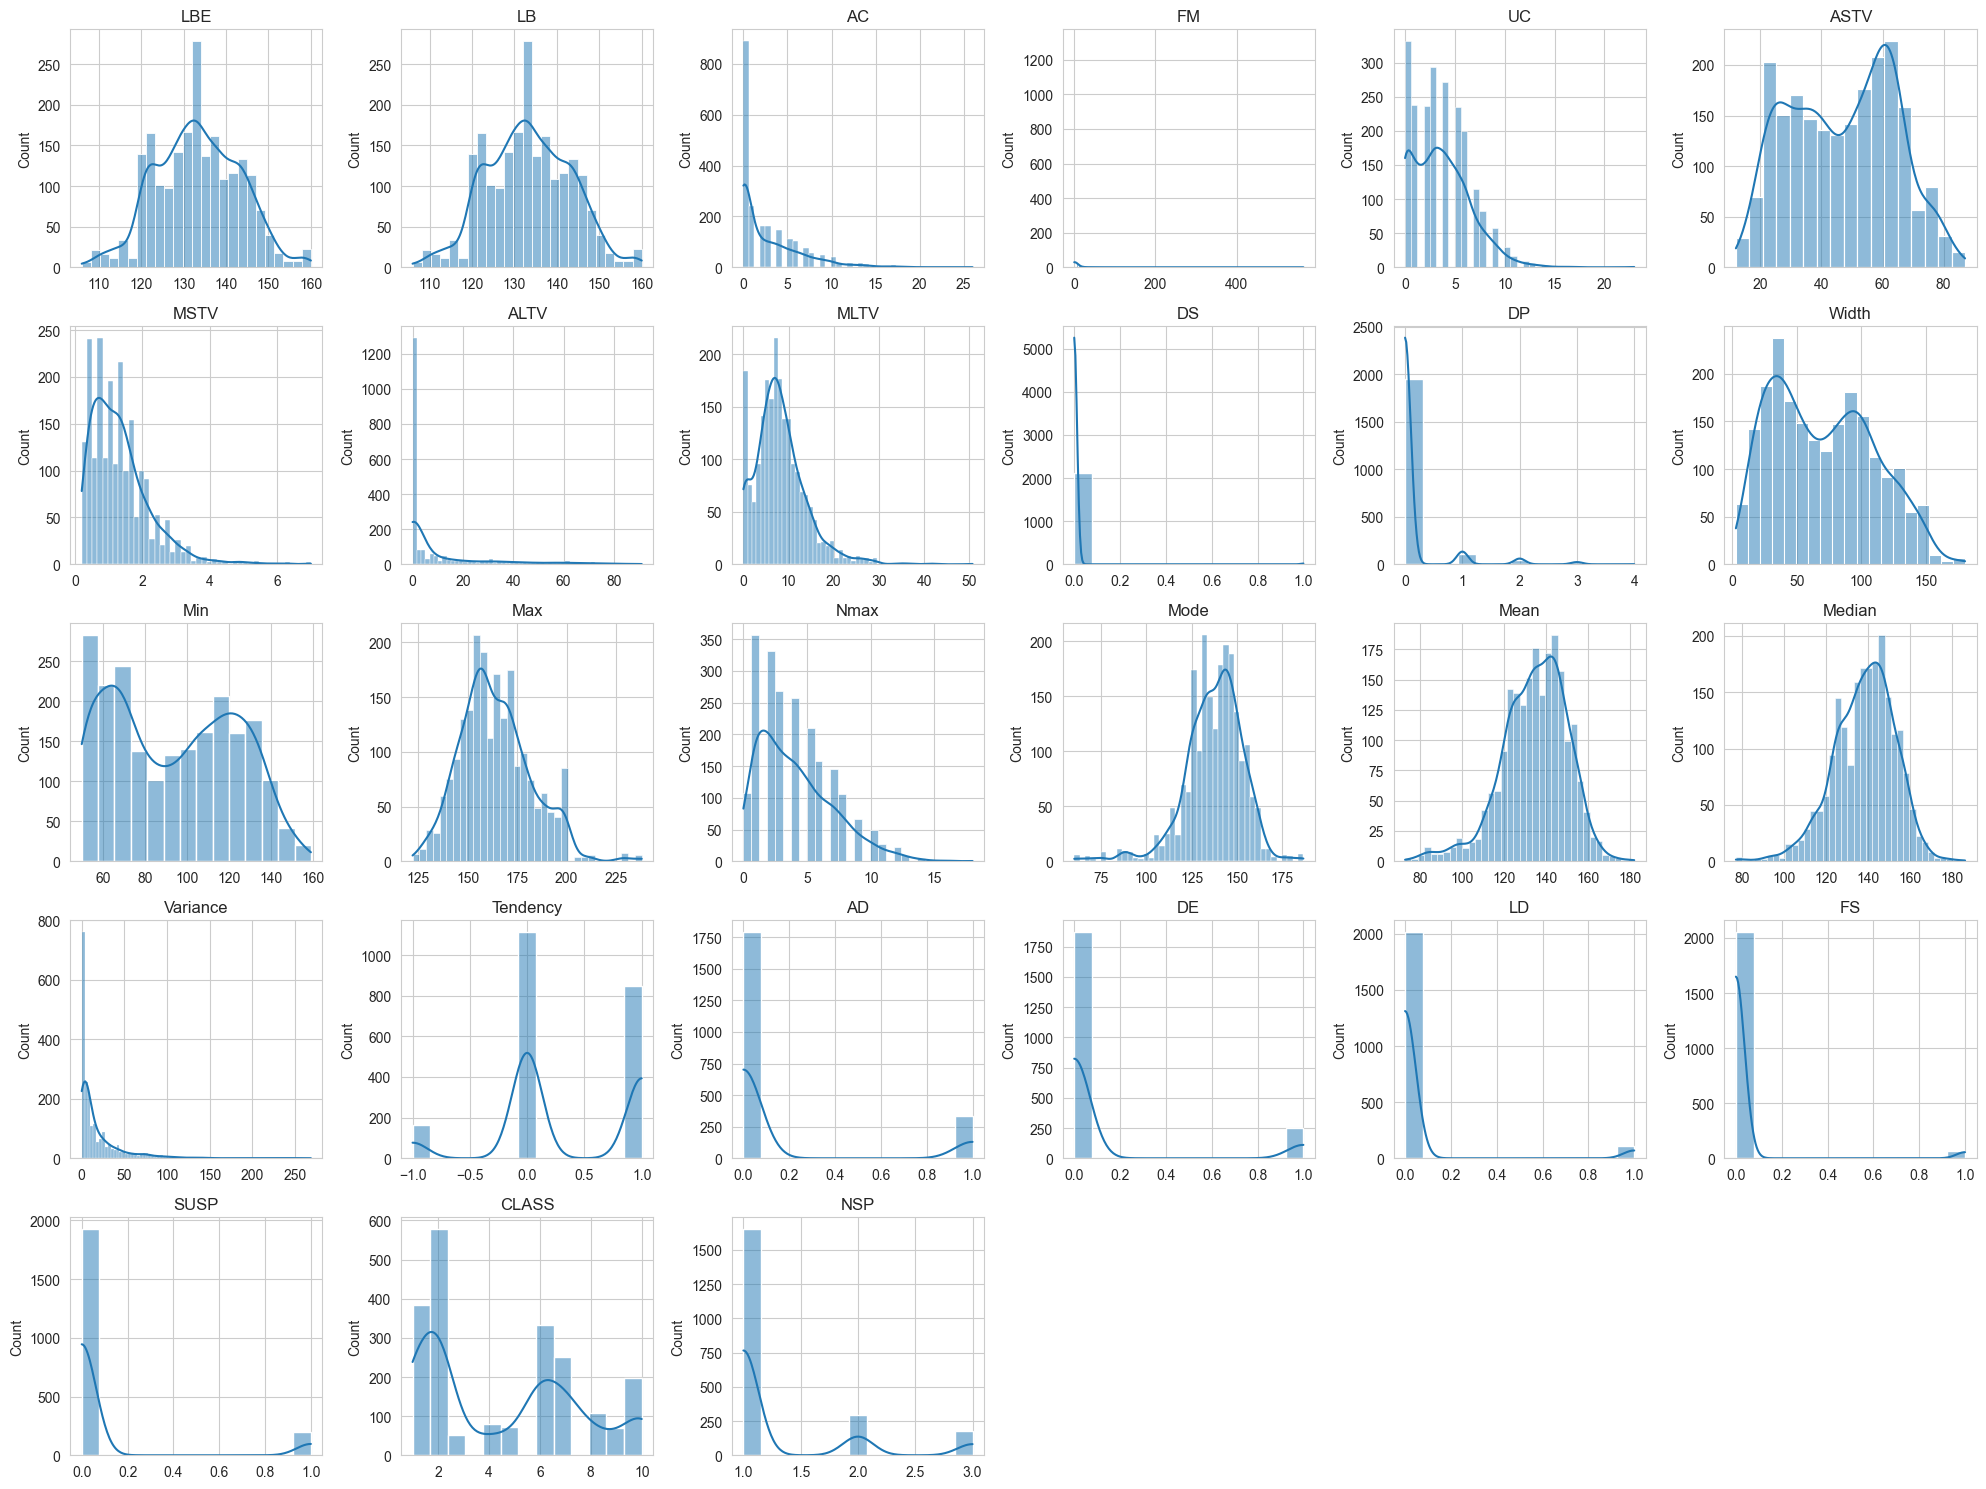

In [45]:
crear_histogram(data)

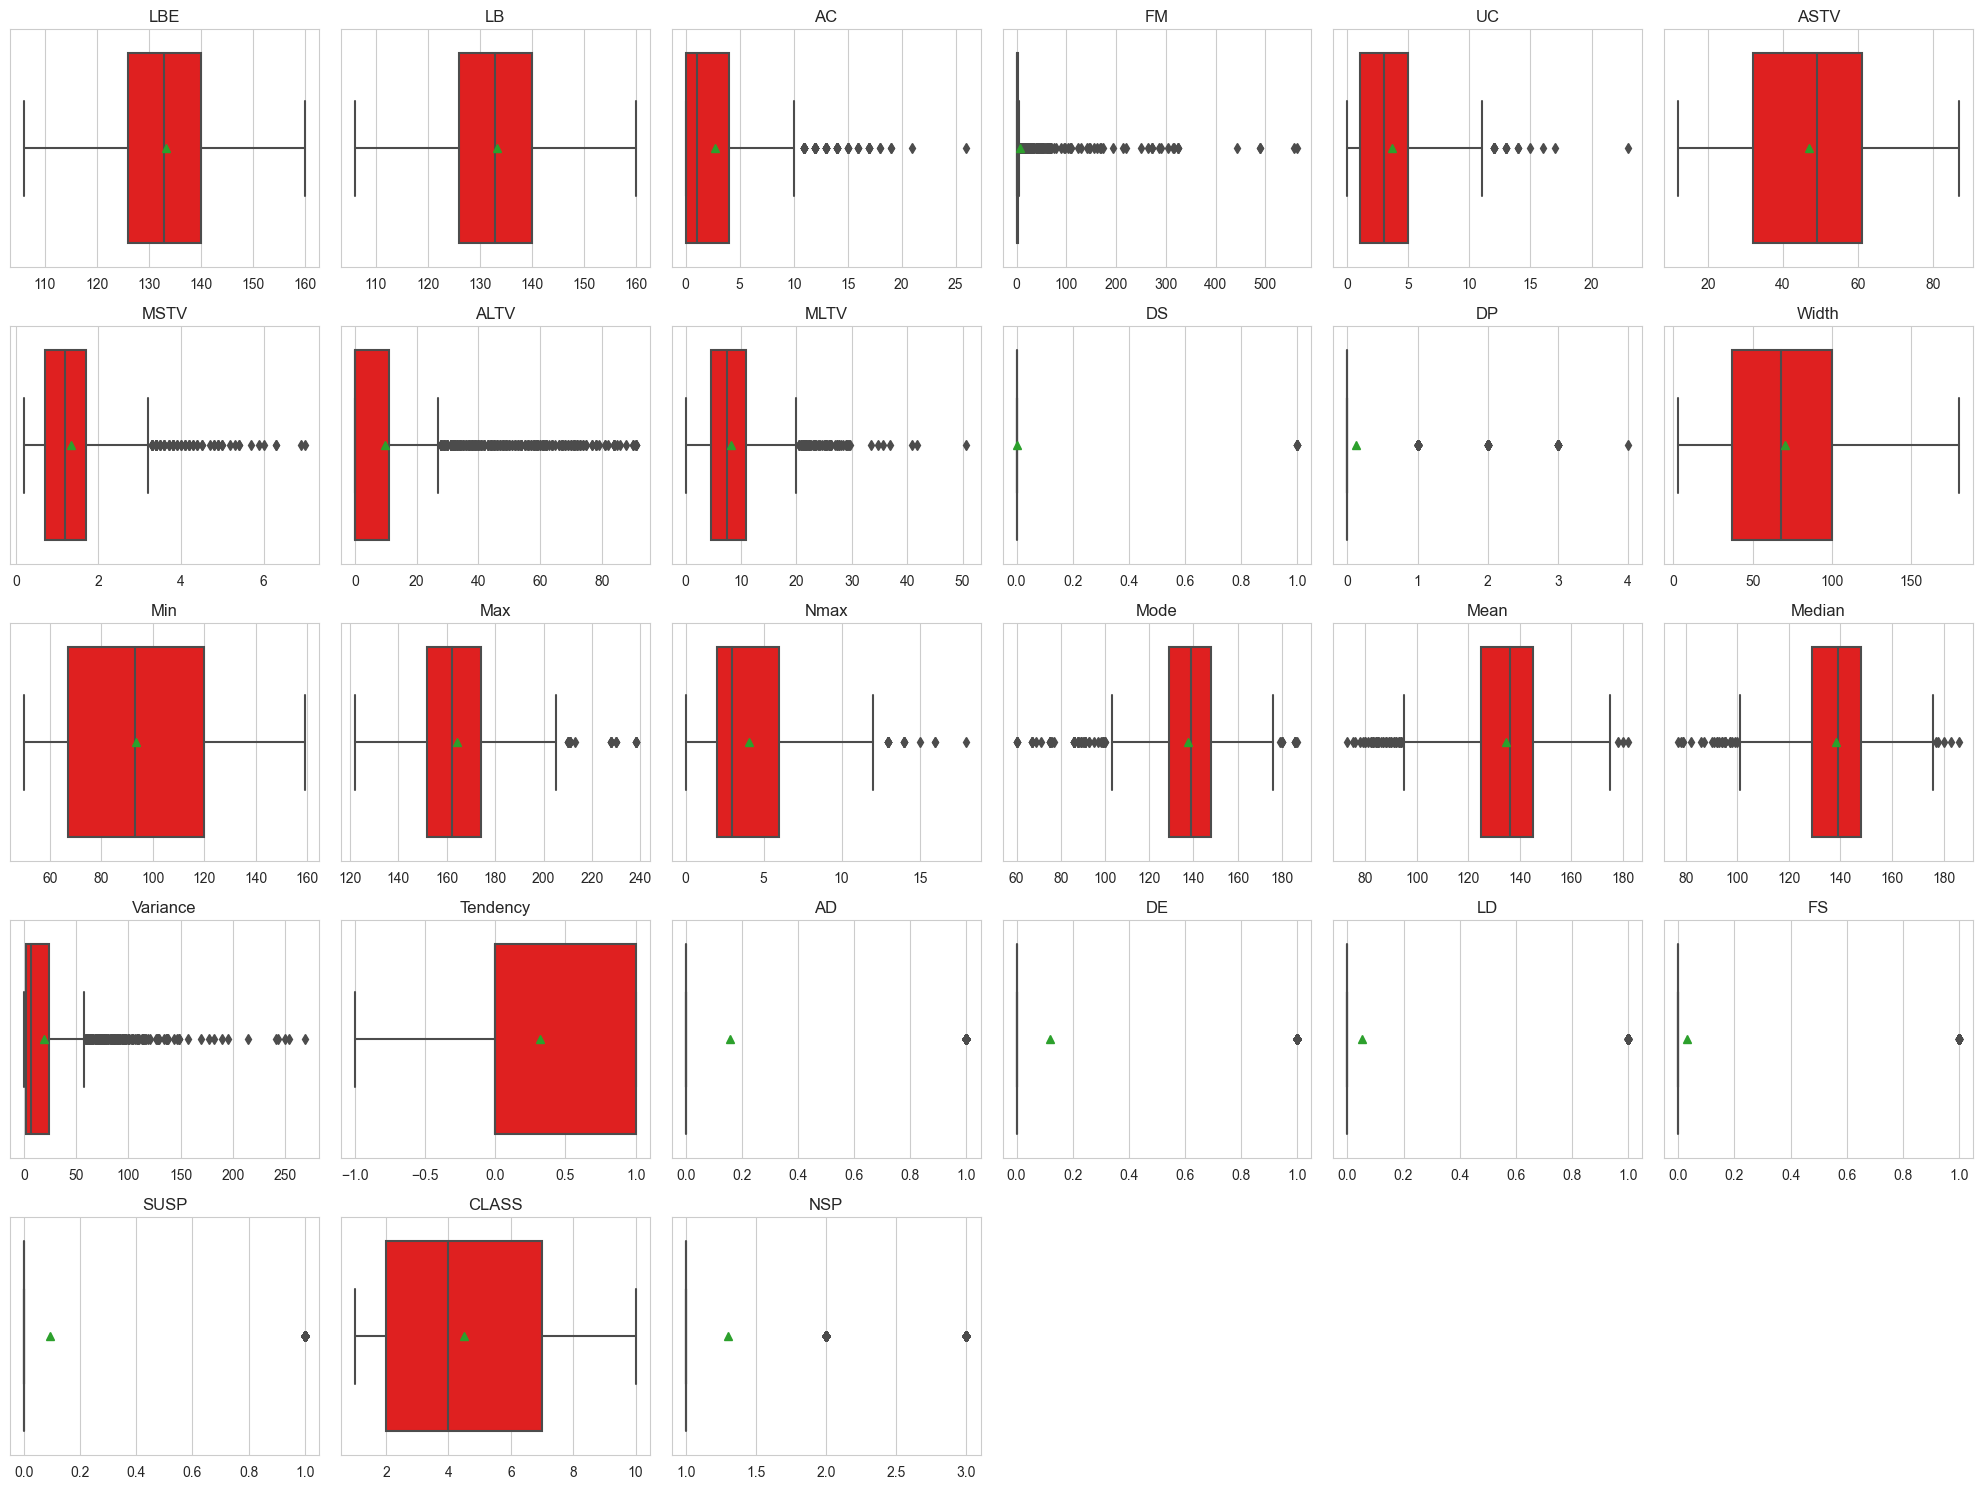

In [46]:
boxplot(data)

# Analisis de datos crudos
El analisis crudo de los datos mostrados en las graficas de histogramas como el grafico de caja demuestra que existen ouliers en variables donde debería haber solo 1 y 0, existen valores flotantes asi como otras variables que salen de la media y caen muy fuera de la desviacion estandar. Tambien podemos rescatar que existen variables que podemos manejarlas como categoricas como son: "Class", "SUSP", "NSP, "Tendency",.

variables que tienen una distribucion uniforme como son: "LBE","LB","ASTV","Width",","Max", "Mdode", "Mean" y Median se puede utilizar la funcion z-score que es una medida estadistica que nos indica cuantas desviaciones estandar un dato esta por encima o por debajo de la media del conjunto de datos. vamos a usar un ubral de 3 desviaciones estandar respecto a la media que representan el 99.7% de los datos. Sabiendo esto, podemos concluir que los datos que caen mas alla de este umbral son atípicos pues son distintos al 99.7% de los datos

variables que tienen una distribucion sesgada como son "AC,"UC","MSTV","ALTV","MLTV","DL" y "Variance" se puede utilizar el metodo Rango Intercuartilico(IQR) 

# Variabales Categoricas

In [48]:
categorical = ['NSP','CLASS','Tendency','SUSP']
data[categorical] = data[categorical].astype(str)

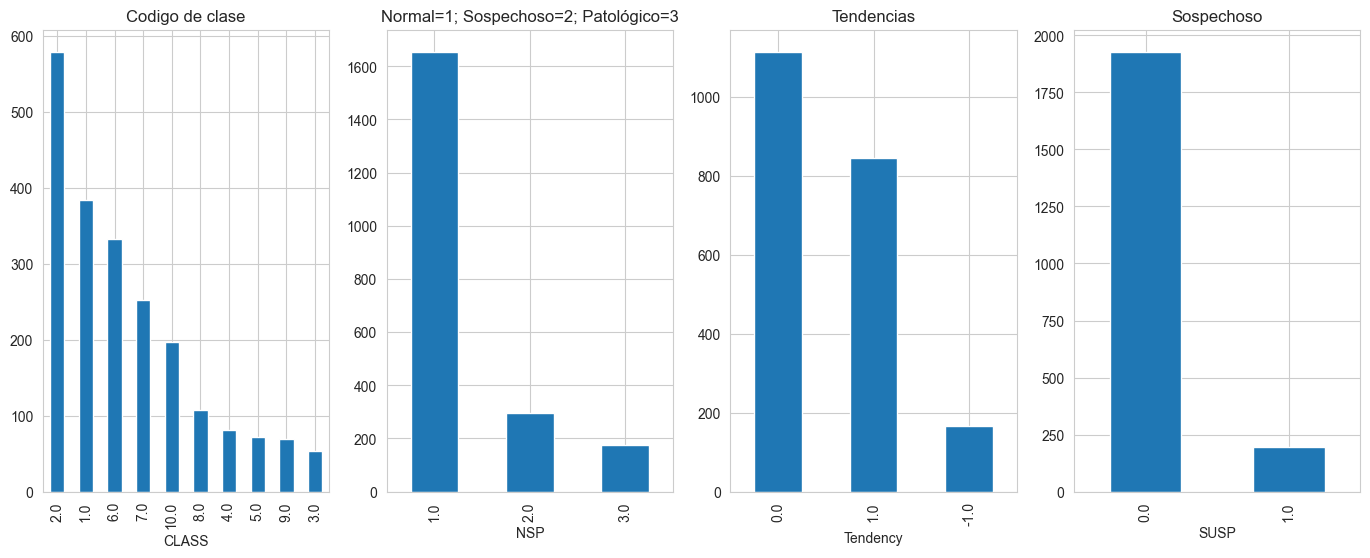

In [52]:
# Obtener el recuento de cada clase
Class_count = data['CLASS'].value_counts()
NSP_count = data['NSP'].value_counts()
tendency_count = data['Tendency'].value_counts()
suspect_count = data['SUSP'].value_counts()


# Crear el gráfico de barras
fig, axes = plt.subplots(1,4, figsize=(17, 6))

# Añadir etiquetas y título
Class_count.plot(x = Class_count.index, y= Class_count, kind = "bar", title = 'Codigo de clase', ax = axes[0])
NSP_count.plot(x = NSP_count.index, y = NSP_count, kind = "bar", title = 'Normal=1; Sospechoso=2; Patológico=3', ax = axes[1])
tendency_count.plot(x = tendency_count.index, y = tendency_count, kind = "bar", title = 'Tendencias', ax = axes[2])
suspect_count.plot(x = suspect_count.index, y=suspect_count, kind = "bar", title = 'Sospechoso', ax = axes[3])
# Mostrar el gráfico
plt.show()

In [24]:
data = otliers(data,"Variance")

In [9]:
data.describe()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Median,Variance,Tendency,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,133.303857,2.722484,7.241298,3.659925,46.990122,1.332785,9.84666,8.187629,1.570085,...,138.090310,18.808090,0.320320,0.156162,0.118532,0.050329,0.032455,0.092662,4.509878,1.304327
std,9.840844,9.840844,3.560850,37.125309,2.847094,17.192814,0.883241,18.39688,5.628247,2.499229,...,14.466589,28.977636,0.610829,0.363094,0.323314,0.218675,0.177248,0.290027,3.026883,0.614377
min,106.000000,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,0.000000,...,77.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,126.000000,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,0.00000,4.600000,0.000000,...,129.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,133.000000,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,0.00000,7.400000,0.000000,...,139.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,140.000000,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,11.00000,10.800000,3.000000,...,148.000000,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
max,160.000000,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,91.00000,50.700000,16.000000,...,186.000000,269.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000


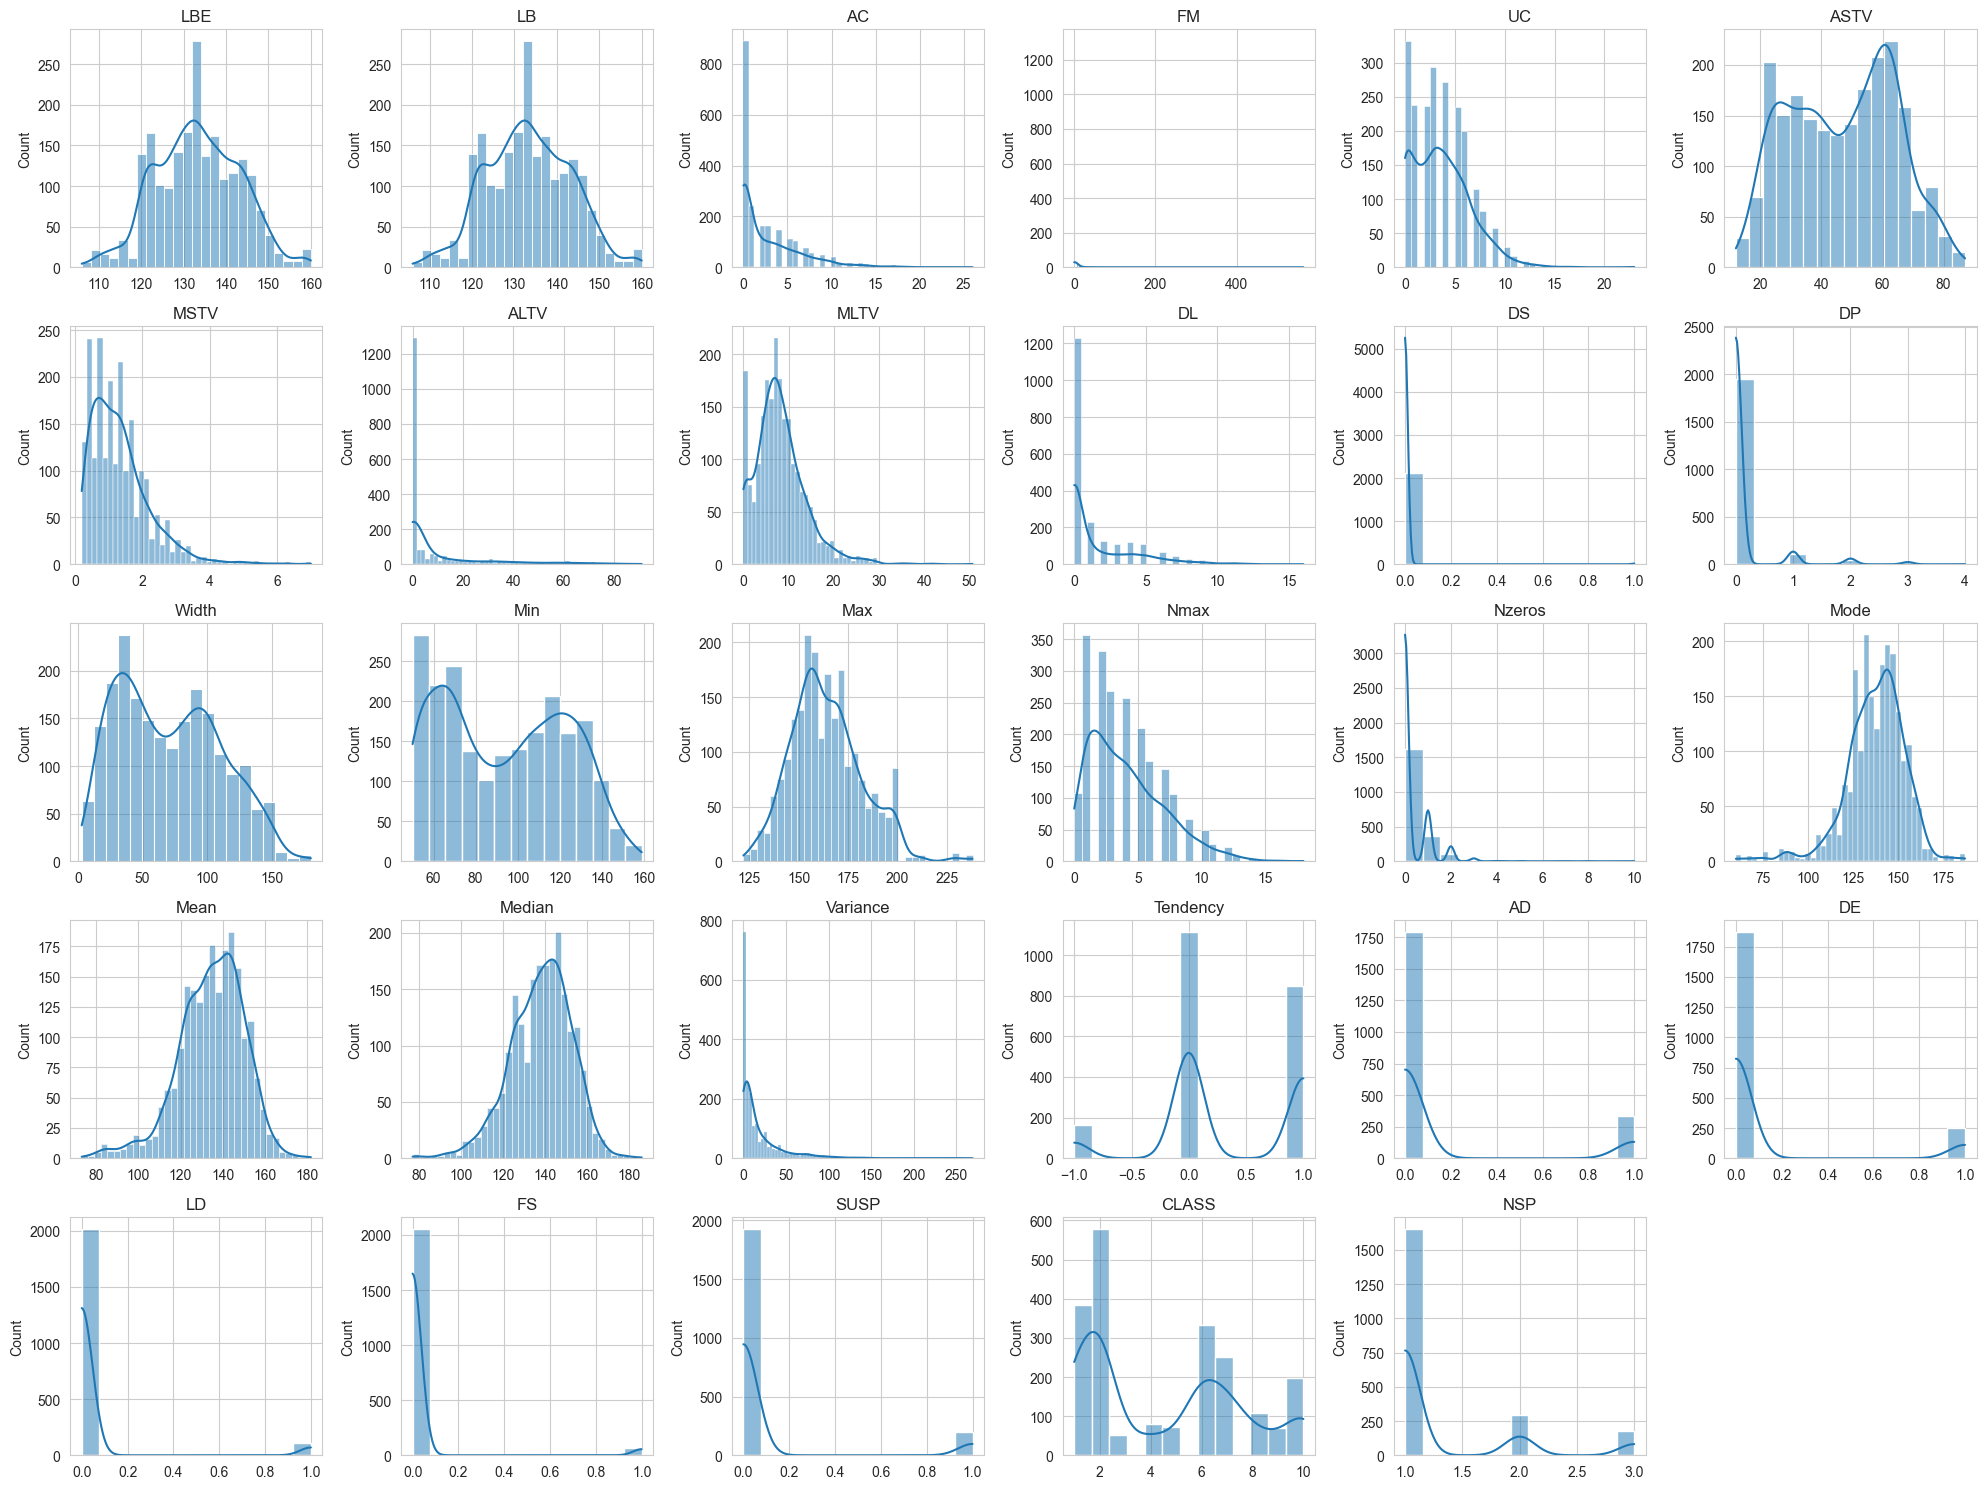

In [10]:
crear_histogram(data)

In [ ]:
categorical = ['NSP','CLASS','Tendency','SUSP']
data[categorical] = data[categorical].astype(str)

In [ ]:
# De las variables categóricas, listar las diferentes categorías y hallar la frecuencia de cada una de ellas

# Obtener el recuento de cada clase
Class_count = data['CLASS'].value_counts()
NSP_count = data['NSP'].value_counts()
tendency_count = data['Tendency'].value_counts()
suspect_count = data['SUSP'].value_counts()
# Crear el gráfico de barras
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

# Añadir etiquetas y título
Class_count.plot(x = Class_count.index, y= Class_count, kind = "bar", title = 'Codigo de clase', ax = axes[0])
NSP_count.plot(x = NSP_count.index, y = NSP_count, kind = "bar", title = 'NSP', ax = axes[1])
tendency_count.plot(x = tendency_count.index, y = tendency_count, kind = "bar", title = 'Tendencias', ax = axes[2])
suspect_count.plot(x = suspect_count, y=suspect_count, kind = "bar", title = 'Sospechoso', ax = axes[3])
# Mostrar el gráfico
plt.show()

destacar puntos importantes del analisis estadistico de las variables categoricas

# Correlacion

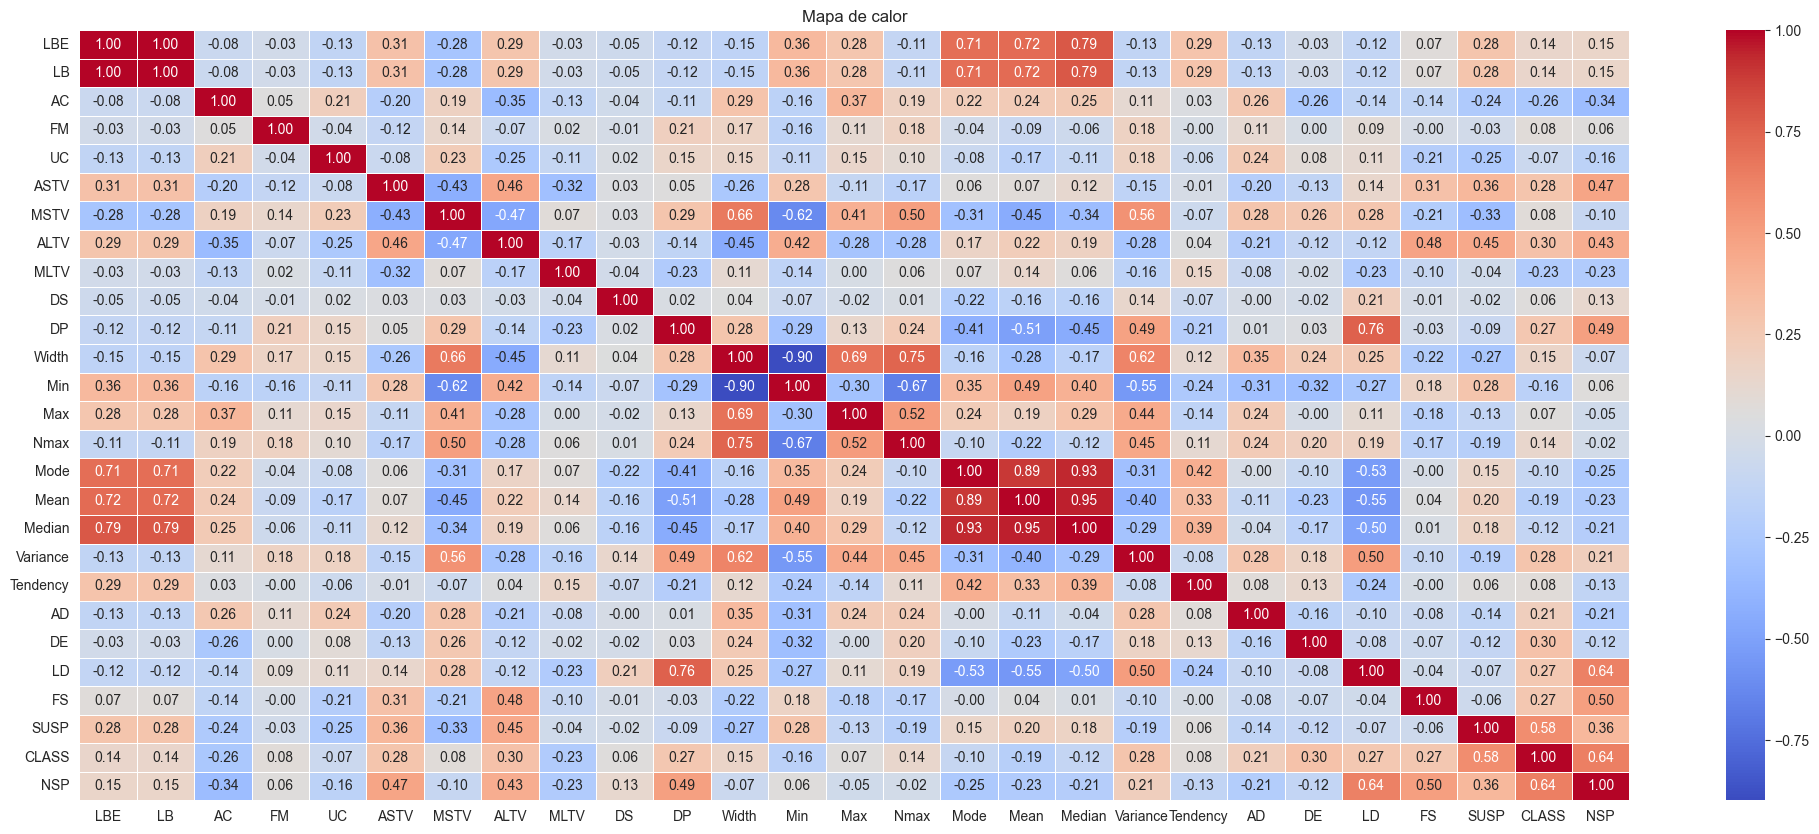

In [53]:
correlacion = data.corr()
plt.figure(figsize=(25,10))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt= '.2f',linewidths=.5)
plt.title('Mapa de calor')
plt.show()


destacar puntos importantes del analisis estadistico del mapa de calor